# Raw Data Example

This notebook shows an example of how to use XDMoD's `rawdata` access APIs obtain and process individual records. In this case we will use the job performance data, which is contained in the `SUPREMM` realm in XDMoD and use this to train a machine learning model.

## Module imports

In this example, we import some libraries that are used for the display and formatting of data as well as the main XDMoD API import.

In [36]:
# system packages that are used in this example workbook
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
from IPython.display import display, Markdown, JSON

# Main imoprt of XDMoD API
import xdmod.datawarehouse as xdw

## Configuration

To access the data in XDMoD you need to know the URL of the XDMoD instance. You will also need an API key or equivalent authentication information. In this prototype the API key is set to `None` which causes the python code to pull the authentication data from a shell environment variable.

In [56]:
XDMOD_URL = "https://xdmod-dev.ccr.xdmod.org"
XDMOD_API_KEY = None



## Obtain the data

The `rawdata` function returns a pandas dataframe containing the individual records for a given realm. You must specfy a time range and which fields to return. You can also optionally specify a set of filters.

<div class="alert alert-block alert-info">
   Note: Filters must be specified using their internal identifiers in this version of the API. 
    </div

In [57]:
with xdw.DataWareHouse(XDMOD_URL, XDMOD_API_KEY) as x:
    supremmjobs = x.rawdata(start = '2021-05-01',
                            end = '2021-05-02', 
                            realm='SUPREMM',
                            stats=['CPU User',
                                   'Nodes',
                                   'Wall Time',
                                   'Wait Time',
                                   'Requested Wall Time',
                                   'Application',
                                   'Total memory used',
                                   'Mount point "home" data written',
                                   'Mount point "scratch" data written'],
                            filters = {
                                'resource': [
                                    '2825',
                                    '2900'
                                ]
                            }
                           )

    # set the stats parameter to an empty array [] to get all data fields: stats=[]
    # set the filters parameter to an empty dict to not apply filters:    filters={}

## Inspect the data

The `supremmjobs` variable now contains a pandas dataset with the requested columns

In [58]:
print(type(supremmjobs))

<class 'pandas.core.frame.DataFrame'>


In [59]:
supremmjobs

,Nodes,Requested Wall Time,Wait Time,Wall Time,CPU User,"Mount point ""home"" data written","Mount point ""scratch"" data written",Total memory used
0,1.0,18000.0,2223.0,61.0,45.336802,NaN,NaN,NaN
1,1.0,3600.0,5602.0,1543.0,99.360662,NaN,NaN,5.712465e+10
2,1.0,21600.0,107620.0,5976.0,5.880115,NaN,NaN,1.681708e+11
3,2.0,86400.0,62768.0,29837.0,98.369553,NaN,NaN,4.094812e+11
4,1.0,3600.0,5282.0,1906.0,98.678836,NaN,NaN,1.184484e+11
...,...,...,...,...,...,...,...,...
34663,1.0,21600.0,279846.0,5904.0,5.888494,NaN,NaN,2.631413e+11
34664,4.0,660.0,15.0,15.0,1.634892,395.289926,0.0,1.491089e+08
34665,1.0,21600.0,279665.0,6098.0,5.996600,NaN,NaN,1.227764e+11
34666,1.0,21600.0,279846.0,5917.0,5.968717,NaN,NaN,2.632364e+11


## Prepare data for training

Looking at the summary table we see that there are some records that have `NaN` values in for certain records. This is not unusal and is typically because the data were not collected (errors in the data collection, insufficient data points, etc.).

To prepare for training, we'll filter the jobs to only one that have complete records and split them into a training set and test set:


In [60]:
# Filter out jobs with no filesystem data
supremmjobs = supremmjobs[supremmjobs['Mount point "scratch" data written'].notnull()]

# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
X = supremmjobs[['Nodes',
            'Wall Time',
            'Wait Time',
            'Requested Wall Time',
            'Total memory used',
            'Mount point "home" data written',
            'Mount point "scratch" data written'
           ]]
                           
y =supremmjobs['CPU User']

# split dataset into training set and test set
fraction_test = 0.10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=fraction_test)
display(Markdown("Size of the test subset is **" + str(len(X_test)) + "**."))
display(Markdown("Size of the training subset is **" + str(len(X_train)) + "**."))

Size of the test subset is **997**.

Size of the training subset is **8966**.

## Generate a Random Forest model

Using the tools from `scikit-learn` build a random forest regression model

In [61]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error
import seaborn as sns

RandomForestRegModel = RandomForestRegressor()
RandomForestRegModel.fit(X_train, y_train)

RandomForestRegressor()

## Compute feature importances

In [62]:
import numpy as np
importances = RandomForestRegModel.feature_importances_
std = np.std([tree.feature_importances_ for tree in RandomForestRegModel.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Calculate feature importances
importances = RandomForestRegModel.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X_train.columns[i] for i in indices]

md = "|Feature Name | Importance |\n|-------|:----|\n"
for i in indices:
    md += "|{}|{:1.4}|\n".format(names[i], importances[i])
    
display(Markdown(md))

|Feature Name | Importance |
|-------|:----|
|Mount point "home" data written|0.378|
|Requested Wall Time|0.2381|
|Wall Time|0.09969|
|Mount point "scratch" data written|0.09403|
|Wait Time|0.07477|
|Total memory used|0.06027|
|Nodes|0.05512|


 Training data r_squared 0.9883
 Test data r_squared 0.9377


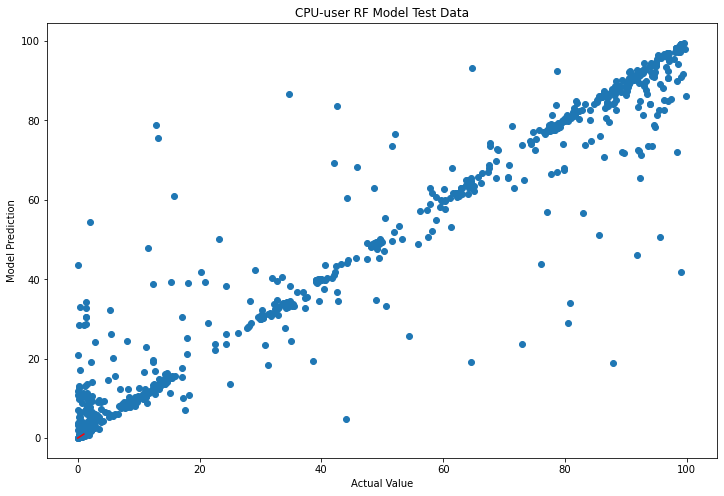

In [63]:
X_train_predict = RandomForestRegModel.predict(X_train)
print(" Training data r_squared"  ,round(r2_score(X_train_predict, y_train),4))
X_test_predict = RandomForestRegModel.predict(X_test)
print(" Test data r_squared"  ,round(r2_score(X_test_predict, y_test),4))

# make model vs actual scatter plot of CPU-user
import matplotlib.pyplot as plt
plt.scatter(y_test,X_test_predict)
plt.ylabel('Model Prediction')
plt.xlabel('Actual Value')
plt.title('CPU-user RF Model Test Data')
point1 = [0,0]
point2 = [1,1]
x_values = [point1[0], point2[0]]
y_values = [point1[1], point2[1]]
plt.plot(x_values, y_values,'r')
plt.show()